In [1]:
# Basic imports
import sys

# System path modification
sys.path.insert(0, '..')

import nibabel as nib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from nilearn.image import new_img_like

from nilearn import plotting
import numpy as np
import seaborn as sns

from src.dataset import *

## Load data 

In [2]:
data = load_pickle_data_palettes()

results_pickle_folder = "../pickle/"

# Unpack data
df_X, df_y, df_all, df_FinalCombination = data["df_X"], data["df_y"], data["df_all"], data["df_FinalCombination"]
df_select_features = data["df_select_features"]

# Unpack feature selections
select_RNA, select_CSF, select_gene, select_MRIthickness = df_select_features.T.values

# Unpack colormaps
full_palette, gender_palette, dx_palette = data["colormaps"].values()

In [3]:
data.keys()

dict_keys(['df_X', 'df_y', 'df_all', 'df_FinalCombination', 'dict_select', 'df_select_features', 'colormaps'])

# Import data and convert to Brain altas mapping

In [4]:
select_MRIthickness = [x.replace("_Cortical", "") for x in select_MRIthickness]

In [5]:
local_matrix = pd.read_csv('../pickle/TabNet_local_MRI.csv', names=["Importance"], header=None)
local_matrix.index = select_MRIthickness

In [6]:
mmse_template = pd.read_csv('../figures/adni_feature_importances_MMSE.csv')
mmse_template.set_index("feature", inplace=True)

FileNotFoundError: [Errno 2] No such file or directory: '../figures/adni_feature_importances_MMSE.csv'

In [ ]:
local_matrix = local_matrix.reindex(index=mmse_template.index)

In [ ]:
atlas_path = '../figures/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_1mm.nii.gz'  # Path to the atlas
atlas_img = nib.load(atlas_path)
atlas_data = atlas_img.get_fdata()

# Load region label map from data/AD/Schaefer2018_200Parcels_7Networks_order_info.txt, each line is feature_name,region_label
region_label_map = pd.read_csv('../figures/Schaefer2018_200Parcels_7Networks_order_info.txt')
region_label_map = region_label_map.set_index('feature_name')['region_label']

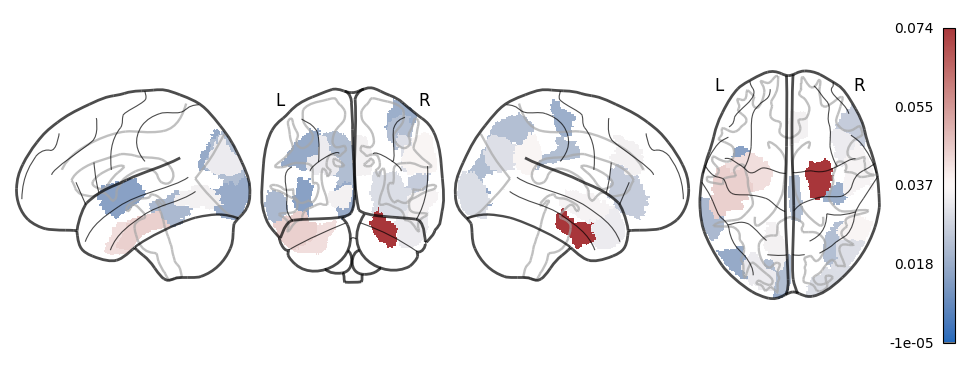

In [ ]:
df = local_matrix.reset_index(names="feature").rename(columns={"Importance":"importance"})

df['abs_importance'] = df['importance'].abs()  # Use absolute importance for ranking
df_sorted = df.sort_values(by='abs_importance', ascending=False).head(20)

# Map feature importance to brain regions
# Assuming the atlas regions are labeled as integers (LH and RH have different IDs)
importance_map = np.zeros_like(atlas_data)

for _, row in df_sorted.iterrows():
    feature_name = row['feature']
    importance_value = row['abs_importance']

    # Extract the region index
    region_label = region_label_map.get(feature_name, None)

    # Map the importance value to the atlas region
    importance_map[atlas_data == region_label] = importance_value

# Create a new NIfTI image with the importance map
importance_img = new_img_like(atlas_img, importance_map)

# Plot the brain map using nilearn's plotting function
plotting.plot_glass_brain(
    importance_img,
    colorbar=True,
    cmap="vlag",
    display_mode='lyrz',
)

plt.savefig(f'../figures/adni_brain_tabnet_local.png')
# Show the plot
plotting.show()

# Feature Importance on Test

### Permutation importance (Pearson scorer)

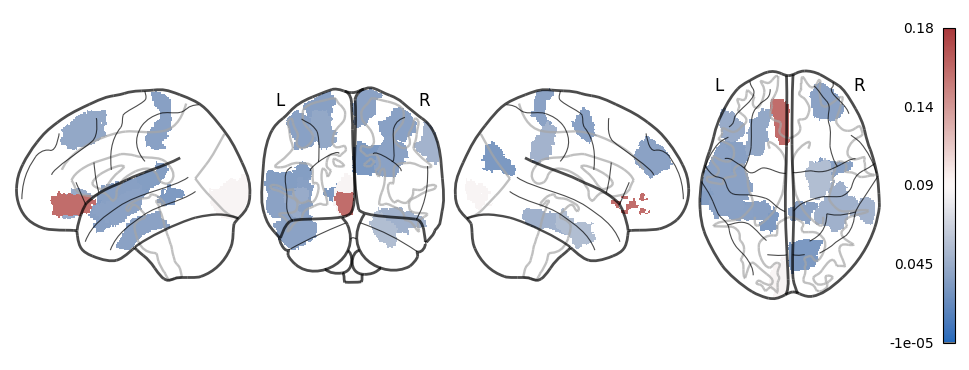

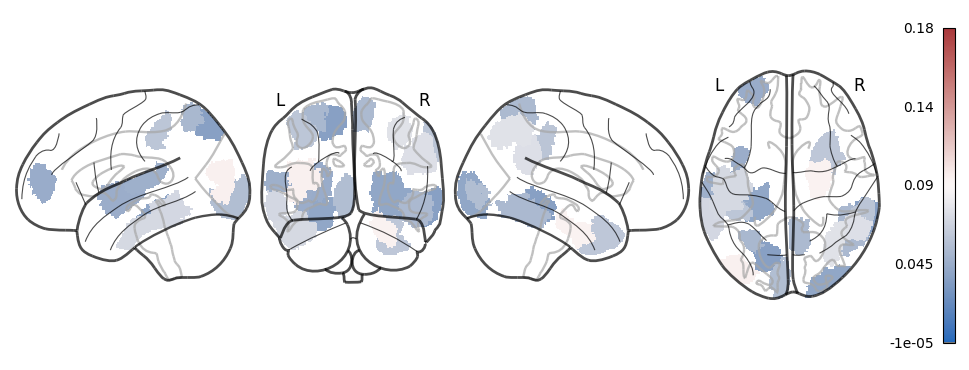

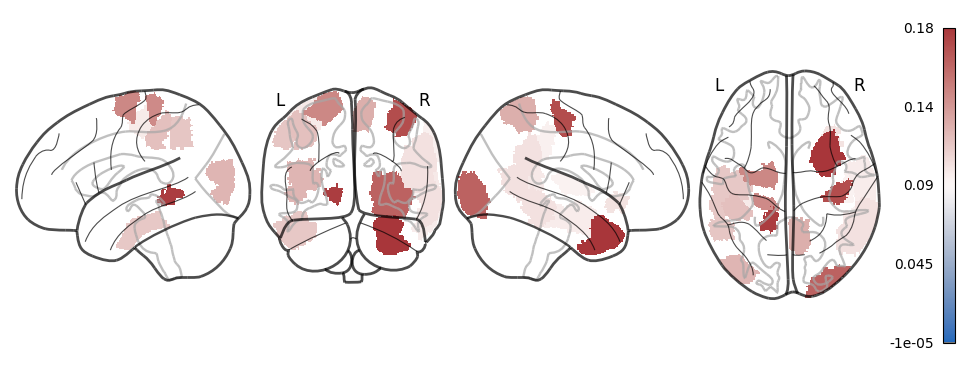

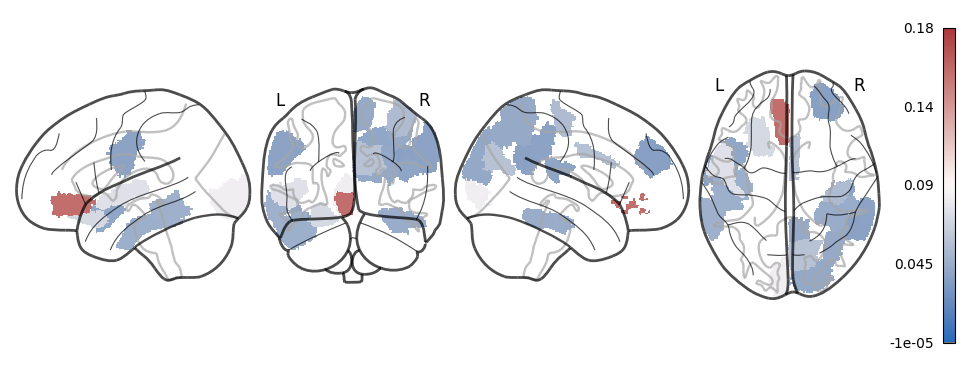

In [ ]:
permutation_matrix = pd.read_csv('../pickle/TabNet_permutation_MRI.csv', names=["Memory", "Executive Function", "Visuospatial", "Language"], header=None)
permutation_matrix.index = select_MRIthickness
permutation_matrix = permutation_matrix.reindex(index=mmse_template.index)

for target in ["Memory", "Executive Function", "Visuospatial", "Language"]:
    df =  permutation_matrix[target].reset_index().rename(columns={target:"importance"})
        
    df['abs_importance'] = df['importance'].abs()  # Use absolute importance for ranking
    df_sorted = df.sort_values(by='abs_importance', ascending=False).head(20)

    # Map feature importance to brain regions
    # Assuming the atlas regions are labeled as integers (LH and RH have different IDs)
    importance_map = np.zeros_like(atlas_data)

    for _, row in df_sorted.iterrows():
        feature_name = row['feature']
        importance_value = row['abs_importance']

        # Extract the region index
        region_label = region_label_map.get(feature_name, None)

        # Map the importance value to the atlas region
        importance_map[atlas_data == region_label] = importance_value

    # Create a new NIfTI image with the importance map
    importance_img = new_img_like(atlas_img, importance_map)

    # Plot the brain map using nilearn's plotting function
    plotting.plot_glass_brain(
        importance_img,
        colorbar=True,
        cmap="vlag",
        display_mode='lyrz',
        vmin=0, 
        vmax=round(permutation_matrix.max().max(), 2)

    )

    plt.savefig(f'../figures/adni_brain_tabnet_permutation_{target.lower()}.png')
    # Show the plot
    plotting.show()

#### Permutation importance (MAE scorer)

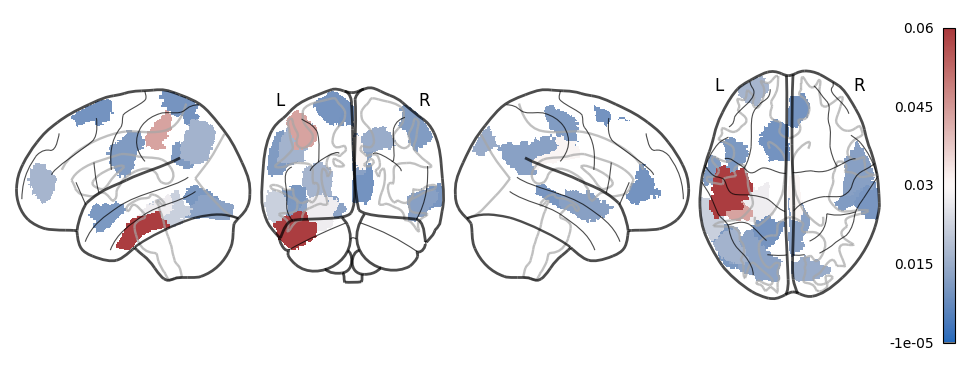

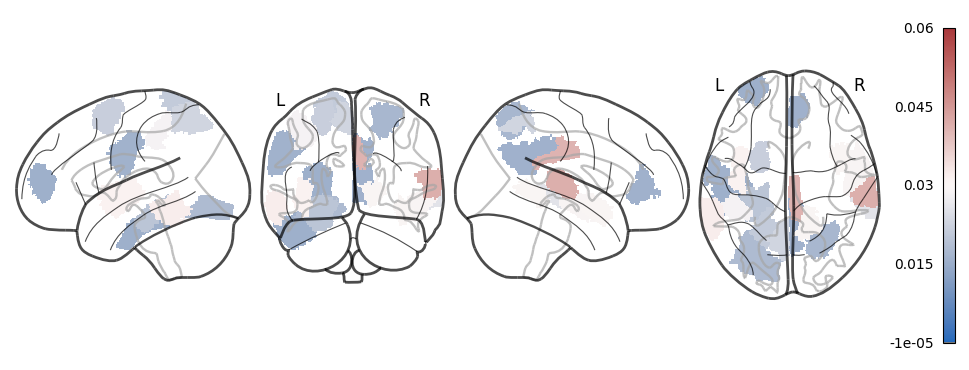

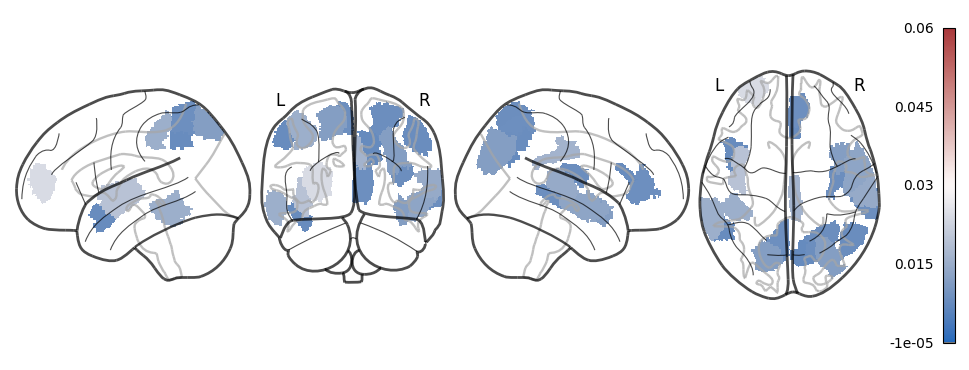

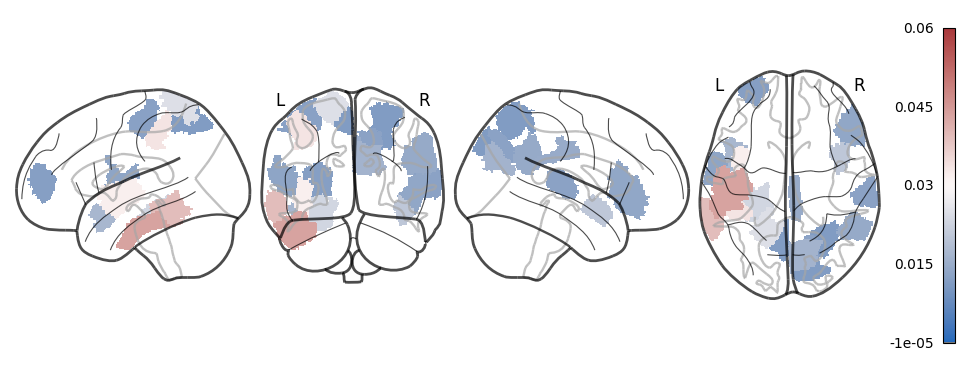

In [ ]:
perm_mae_matrix= pd.read_csv('../pickle/TabNet_permutation_mae_MRI.csv', names=["Memory", "Executive Function", "Visuospatial", "Language"], header=None)
perm_mae_matrix.index = select_MRIthickness
perm_mae_matrix = perm_mae_matrix.reindex(index=mmse_template.index)

for target in ["Memory", "Executive Function", "Visuospatial", "Language"]:
    df =  perm_mae_matrix[target].reset_index().rename(columns={target:"importance"})
        
    df['abs_importance'] = df['importance'].abs()  # Use absolute importance for ranking
    df_sorted = df.sort_values(by='abs_importance', ascending=False).head(20)

    # Map feature importance to brain regions
    # Assuming the atlas regions are labeled as integers (LH and RH have different IDs)
    importance_map = np.zeros_like(atlas_data)

    for _, row in df_sorted.iterrows():
        feature_name = row['feature']
        importance_value = row['abs_importance']

        # Extract the region index
        region_label = region_label_map.get(feature_name, None)

        # Map the importance value to the atlas region[
        importance_map[atlas_data == region_label] = importance_value

    # Create a new NIfTI image with the importance map
    importance_img = new_img_like(atlas_img, importance_map)

    # Plot the brain map using nilearn's plotting function
    plotting.plot_glass_brain(
        importance_img,
        colorbar=True,
        cmap="vlag",
        display_mode='lyrz',
        vmin=0,
        vmax=round(perm_mae_matrix.max().max(), 2)
    )

    plt.savefig(f'../figures/adni_brain_tabnet_permutation_mae_matrix_{target.lower()}.png')
    # Show the plot
    plotting.show()

#### Shapley importance

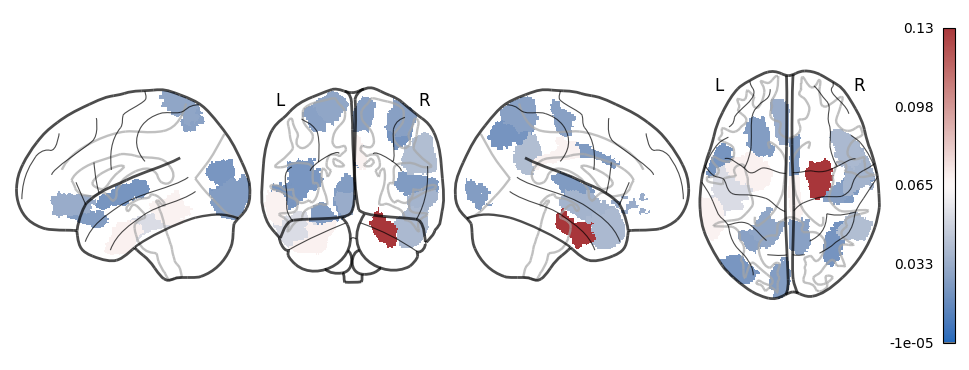

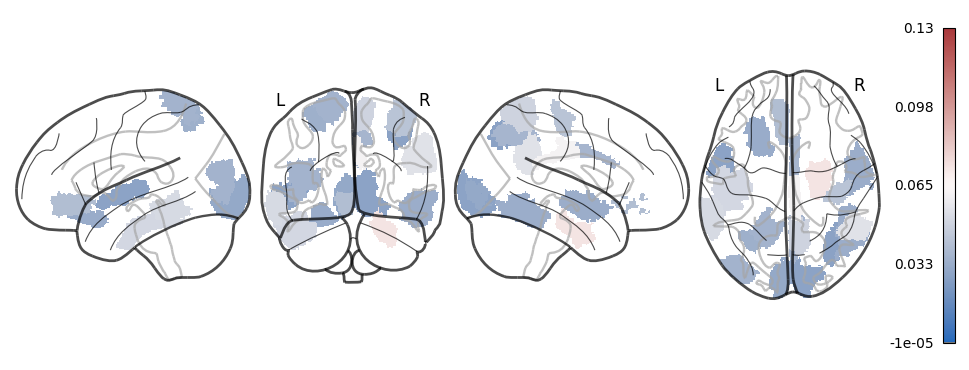

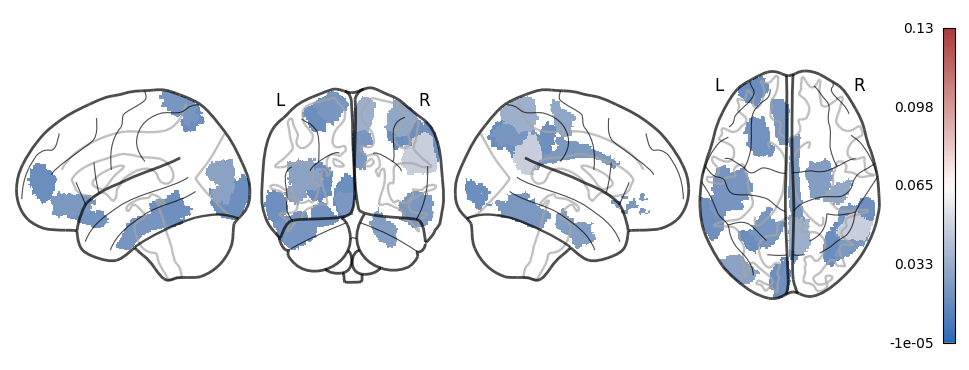

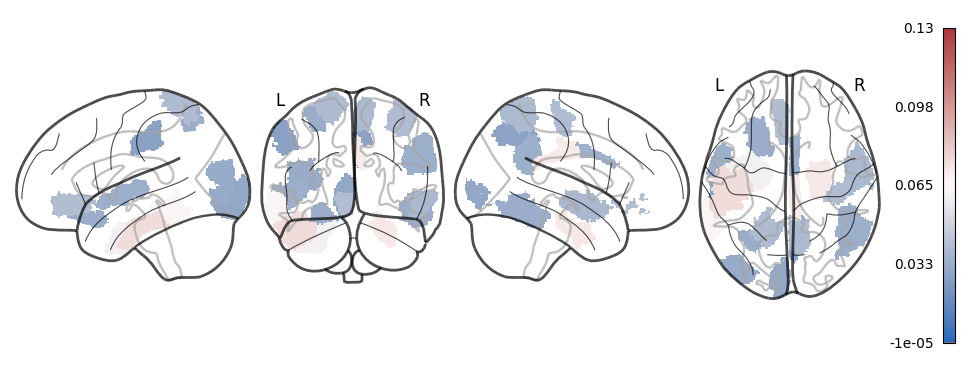

In [ ]:
shap_matrix= pd.read_csv('../pickle/TabNet_shap_MRI.csv', names=["Memory", "Executive Function", "Visuospatial", "Language"], header=None)
shap_matrix.index = select_MRIthickness
shap_matrix = shap_matrix.reindex(index=mmse_template.index)

for target in ["Memory", "Executive Function", "Visuospatial", "Language"]:
    df =  shap_matrix[target].reset_index().rename(columns={target:"importance"})
        
    df['abs_importance'] = df['importance'].abs()  # Use absolute importance for ranking
    df_sorted = df.sort_values(by='abs_importance', ascending=False).head(20)

    # Map feature importance to brain regions
    # Assuming the atlas regions are labeled as integers (LH and RH have different IDs)
    importance_map = np.zeros_like(atlas_data)

    for _, row in df_sorted.iterrows():
        feature_name = row['feature']
        importance_value = row['abs_importance']

        # Extract the region index
        region_label = region_label_map.get(feature_name, None)

        # Map the importance value to the atlas region
        importance_map[atlas_data == region_label] = importance_value

    # Create a new NIfTI image with the importance map
    importance_img = new_img_like(atlas_img, importance_map)

    # Plot the brain map using nilearn's plotting function
    plotting.plot_glass_brain(
        importance_img,
        colorbar=True,
        cmap="vlag",
        display_mode='lyrz',
        vmin=0, 
        vmax=round(shap_matrix.max().max(), 2)
    )

    plt.savefig(f'../figures/adni_brain_tabnet_shap_{target.lower()}.png')
    # Show the plot
    plotting.show()

# Feature importances values on Train

#### Shapley importance

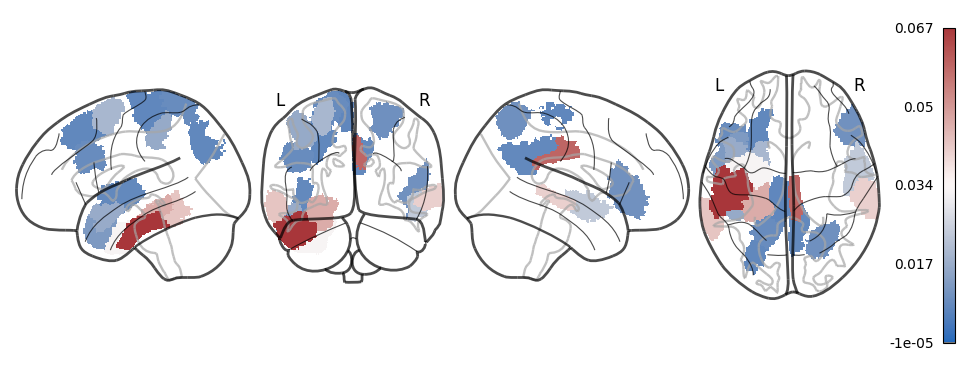

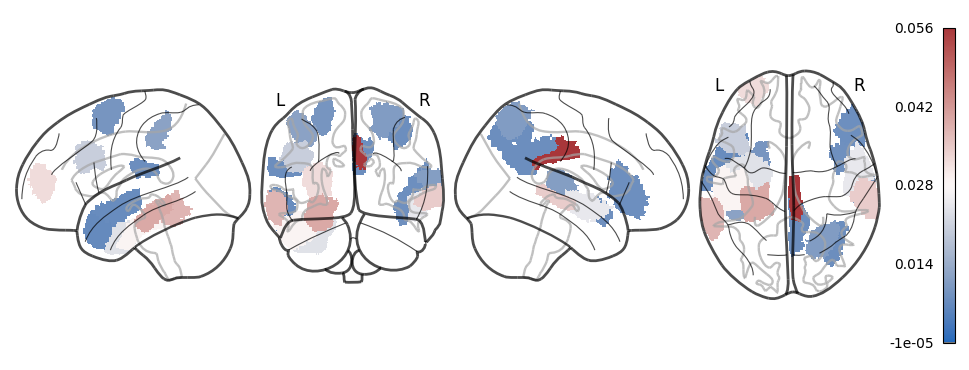

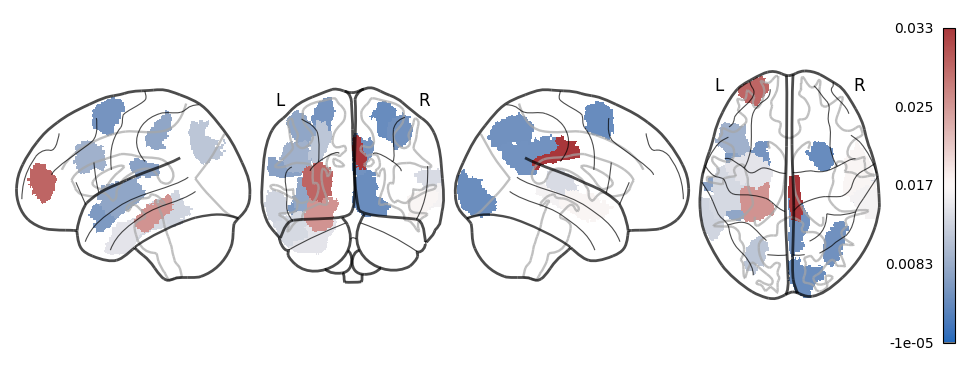

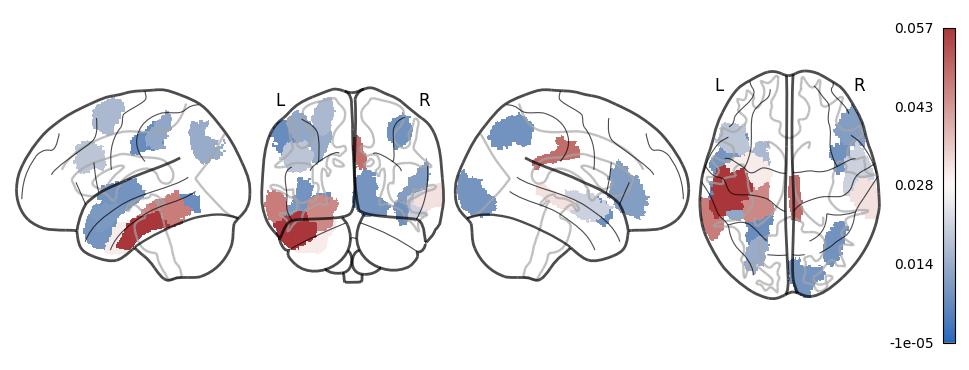

In [ ]:
shap_train_matrix= pd.read_csv('../pickle/TabNet_shap_train_MRI.csv', names=["Memory", "Executive Function", "Visuospatial", "Language"], header=None)
shap_train_matrix.index = select_MRIthickness
shap_train_matrix = shap_train_matrix.reindex(index=mmse_template.index)

for target in ["Memory", "Executive Function", "Visuospatial", "Language"]:
    df =  shap_train_matrix[target].reset_index().rename(columns={target:"importance"})
        
    df['abs_importance'] = df['importance'].abs()  # Use absolute importance for ranking
    df_sorted = df.sort_values(by='abs_importance', ascending=False).head(20)

    # Map feature importance to brain regions
    # Assuming the atlas regions are labeled as integers (LH and RH have different IDs)
    importance_map = np.zeros_like(atlas_data)

    for _, row in df_sorted.iterrows():
        feature_name = row['feature']
        importance_value = row['abs_importance']

        # Extract the region index
        region_label = region_label_map.get(feature_name, None)

        # Map the importance value to the atlas region
        importance_map[atlas_data == region_label] = importance_value

    # Create a new NIfTI image with the importance map
    importance_img = new_img_like(atlas_img, importance_map)

    # Plot the brain map using nilearn's plotting function
    plotting.plot_glass_brain(
        importance_img,
        colorbar=True,
        cmap="vlag",
        display_mode='lyrz',
        vmin=0, 
        #vmax=round(shap_train_matrix.max().max(), 2)
    )

    plt.savefig(f'../figures/adni_brain_tabnet_shap_train_matrix_{target.lower()}.png')
    # Show the plot
    plotting.show()

#### Permutation importance (Pearson scorer)

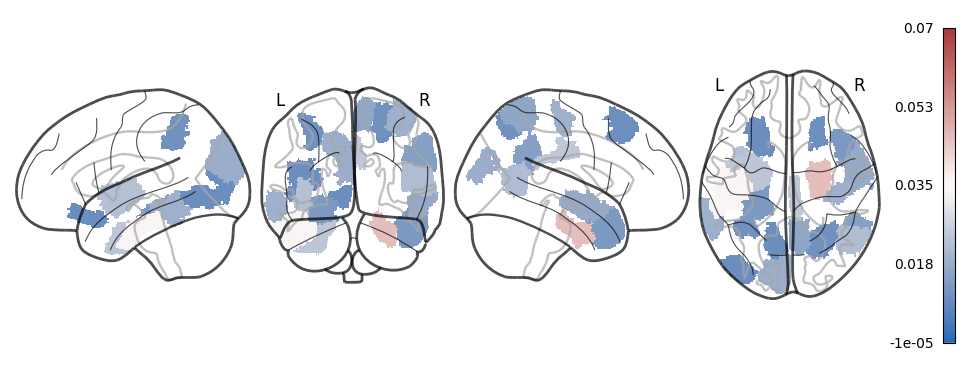

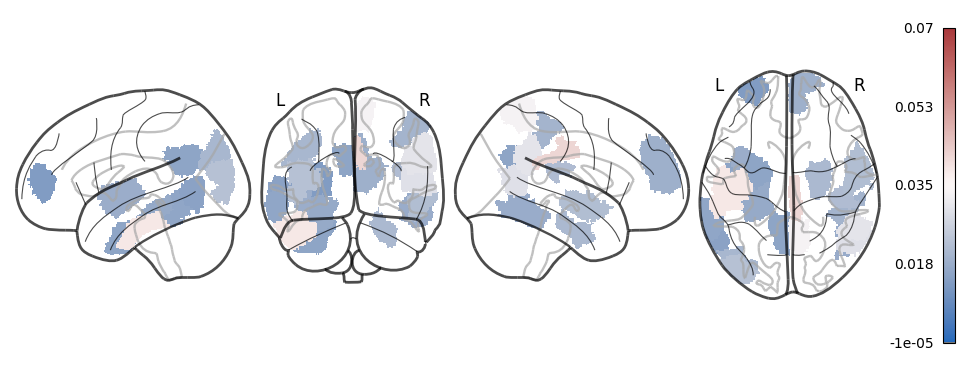

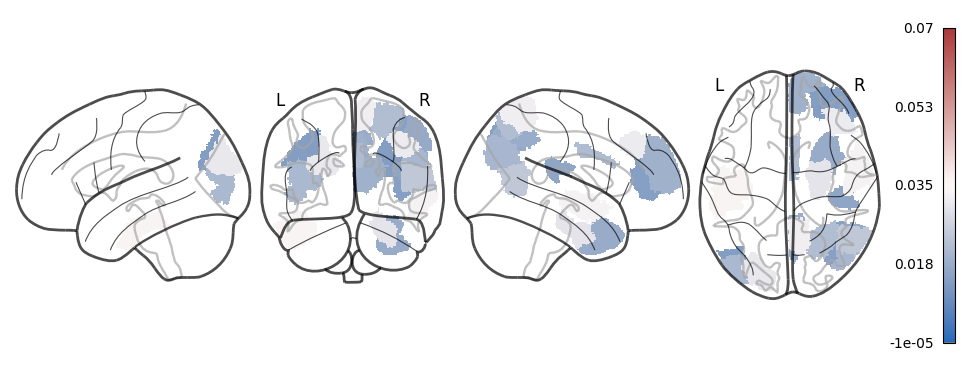

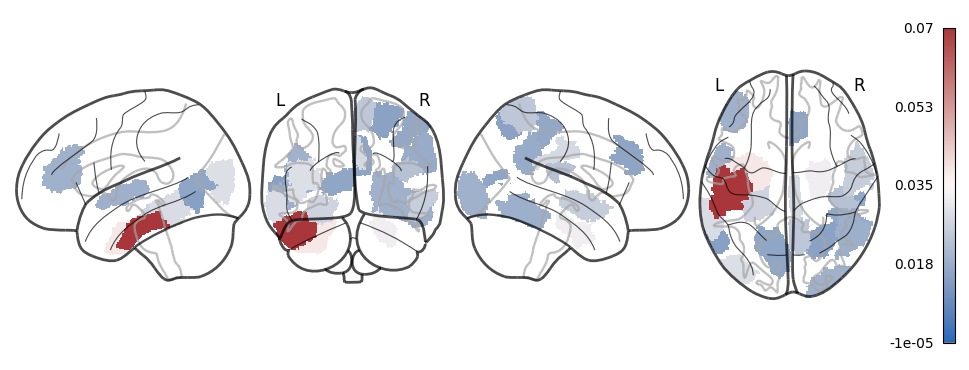

In [ ]:
perm_train_matrix= pd.read_csv('../pickle/TabNet_permutation_train_MRI.csv', names=["Memory", "Executive Function", "Visuospatial", "Language"], header=None)
perm_train_matrix.index = select_MRIthickness
perm_train_matrix = perm_train_matrix.reindex(index=mmse_template.index)

for target in ["Memory", "Executive Function", "Visuospatial", "Language"]:
    df =  perm_train_matrix[target].reset_index().rename(columns={target:"importance"})
        
    df['abs_importance'] = df['importance'].abs()  # Use absolute importance for ranking
    df_sorted = df.sort_values(by='abs_importance', ascending=False).head(20)

    # Map feature importance to brain regions
    # Assuming the atlas regions are labeled as integers (LH and RH have different IDs)
    importance_map = np.zeros_like(atlas_data)

    for _, row in df_sorted.iterrows():
        feature_name = row['feature']
        importance_value = row['abs_importance']

        # Extract the region index
        region_label = region_label_map.get(feature_name, None)

        # Map the importance value to the atlas region
        importance_map[atlas_data == region_label] = importance_value

    # Create a new NIfTI image with the importance map
    importance_img = new_img_like(atlas_img, importance_map)

    # Plot the brain map using nilearn's plotting function
    plotting.plot_glass_brain(
        importance_img,
        colorbar=True,
        cmap="vlag",
        display_mode='lyrz',
        vmin=0,
        vmax=round(perm_train_matrix.max().max(), 2)
    )

    plt.savefig(f'../figures/adni_brain_tabnet_permutation_train_matrix_{target.lower()}.png')
    # Show the plot
    plotting.show()

#### Permutation importance (MAE scorer)

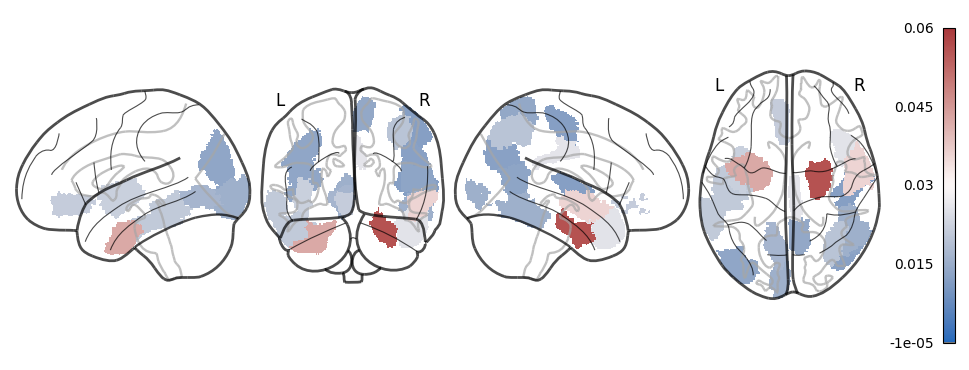

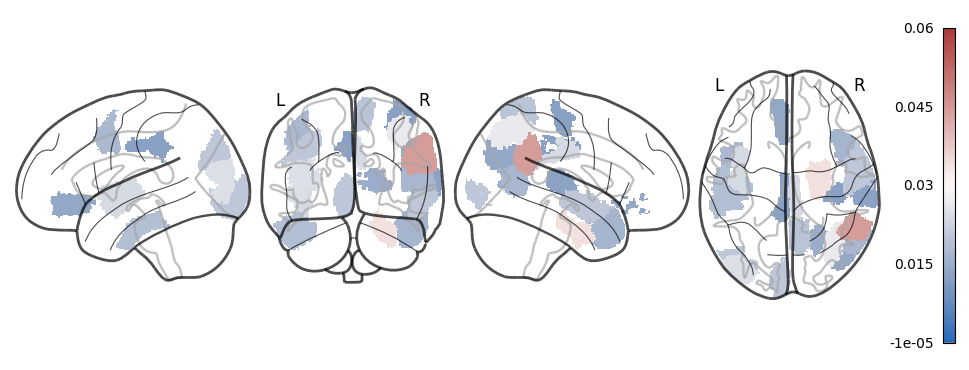

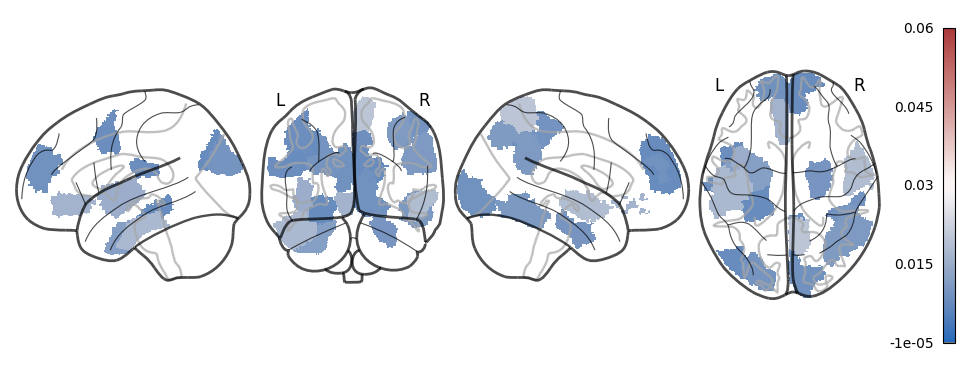

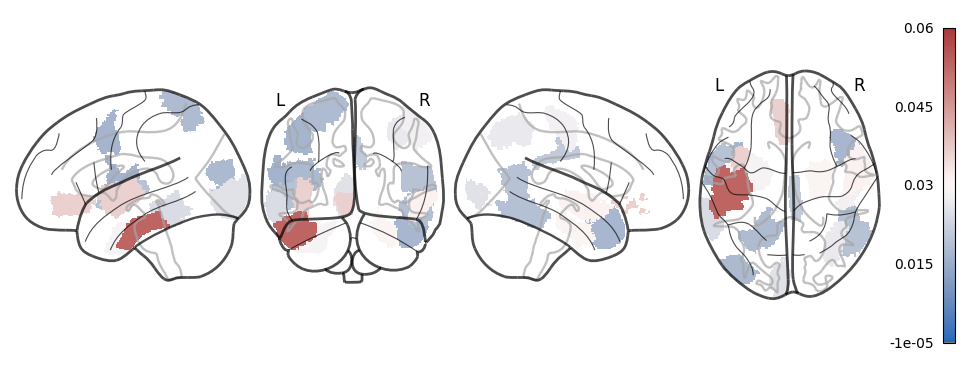

In [ ]:
perm_train_matrix= pd.read_csv('../pickle/TabNet_permutation_mae_train_MRI.csv', names=["Memory", "Executive Function", "Visuospatial", "Language"], header=None)
perm_train_matrix.index = select_MRIthickness
perm_train_matrix = perm_train_matrix.reindex(index=mmse_template.index)

for target in ["Memory", "Executive Function", "Visuospatial", "Language"]:
    df =  perm_train_matrix[target].reset_index().rename(columns={target:"importance"})
        
    df['abs_importance'] = df['importance'].abs()  # Use absolute importance for ranking
    df_sorted = df.sort_values(by='abs_importance', ascending=False).head(20)

    # Map feature importance to brain regions
    # Assuming the atlas regions are labeled as integers (LH and RH have different IDs)
    importance_map = np.zeros_like(atlas_data)

    for _, row in df_sorted.iterrows():
        feature_name = row['feature']
        importance_value = row['abs_importance']

        # Extract the region index
        region_label = region_label_map.get(feature_name, None)

        # Map the importance value to the atlas region
        importance_map[atlas_data == region_label] = importance_value

    # Create a new NIfTI image with the importance map
    importance_img = new_img_like(atlas_img, importance_map)

    # Plot the brain map using nilearn's plotting function
    plotting.plot_glass_brain(
        importance_img,
        colorbar=True,
        cmap="vlag",
        display_mode='lyrz',
        vmin=0,
        vmax=round(perm_train_matrix.max().max(), 2)
    )

    plt.savefig(f'../figures/adni_brain_tabnet_permutation_mae_train_matrix_{target.lower()}.png')
    # Show the plot
    plotting.show()

# Owen values

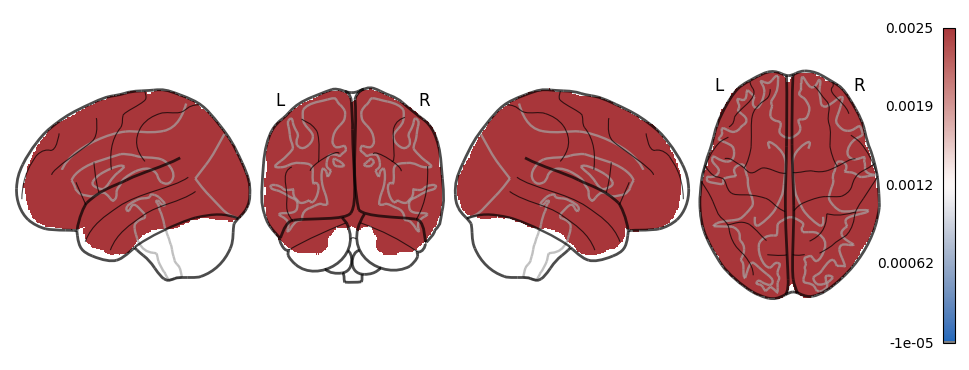

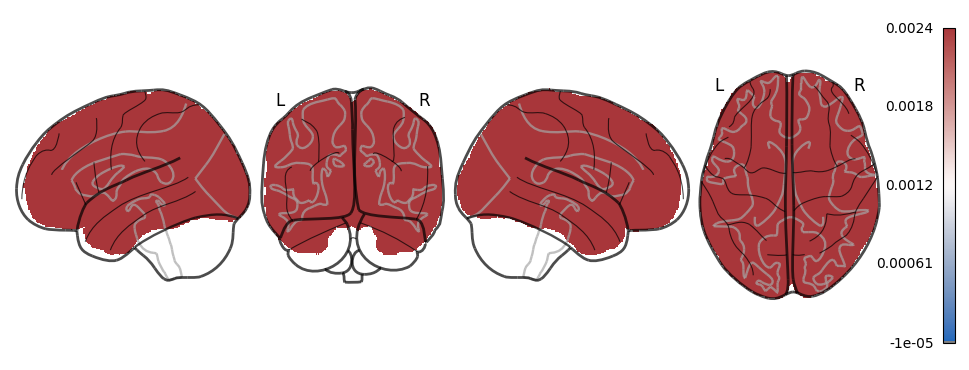

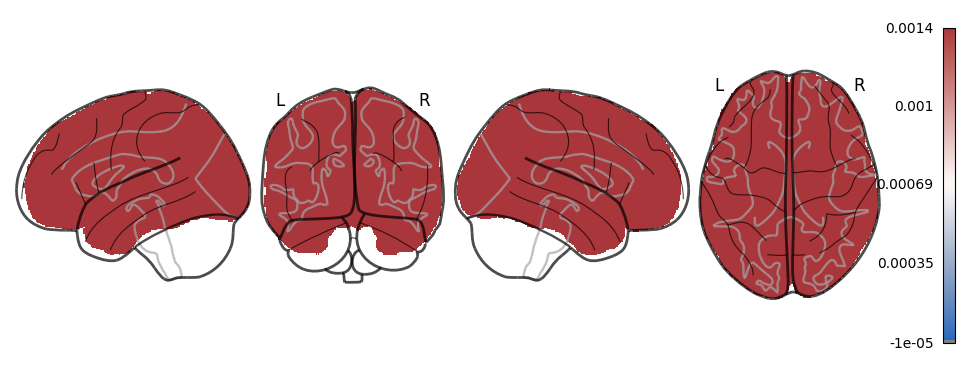

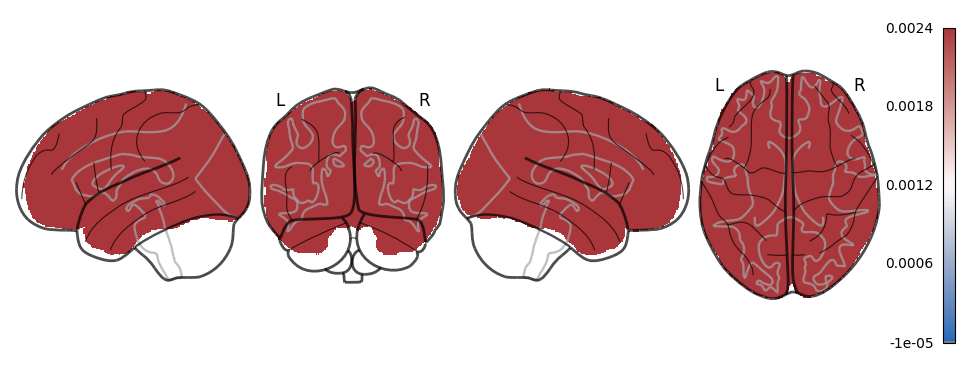

In [ ]:
owen_matrix= pd.read_csv('../pickle/TabNet_owen_train_MRI.csv', names=["Memory", "Executive Function", "Visuospatial", "Language"], header=None)
owen_matrix.index = select_MRIthickness
owen_matrix = owen_matrix.reindex(index=mmse_template.index)

for target in ["Memory", "Executive Function", "Visuospatial", "Language"]:
    df =  owen_matrix[target].reset_index().rename(columns={target:"importance"})
        
    df['abs_importance'] = df['importance'].abs()  # Use absolute importance for ranking
    df_sorted = df.sort_values(by='abs_importance', ascending=False)

    # Map feature importance to brain regions
    # Assuming the atlas regions are labeled as integers (LH and RH have different IDs)
    importance_map = np.zeros_like(atlas_data)

    for _, row in df_sorted.iterrows():
        feature_name = row['feature']
        importance_value = row['importance']

        # Extract the region index
        region_label = region_label_map.get(feature_name, None)

        # Map the importance value to the atlas region
        importance_map[atlas_data == region_label] = importance_value

    # Create a new NIfTI image with the importance map
    importance_img = new_img_like(atlas_img, importance_map)

    # Plot the brain map using nilearn's plotting function
    plotting.plot_glass_brain(
        importance_img,
        colorbar=True,
        cmap="vlag",
        display_mode='lyrz',
    )

    plt.savefig(f'../figures/adni_brain_tabnet_owen_{target.lower()}.png')
    # Show the plot
    plotting.show()